In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import time
import datetime
from scipy import stats
from datetime import date
from datetime import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.svm import SVC
from backports.datetime_fromisoformat import MonkeyPatch

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import folium
from folium.plugins import MarkerCluster
from sklearn.metrics import f1_score

## Useful functions

In [3]:
def get_cat_hour(x) :
    """Function that categorizes hours into categories of different moments of the day
    Takes a time and return a different period of time during the day. 
    Periods of the day are defined above"""
    if x >= late_night and x < rush_am :
        return 'mid_night'
    elif x >= rush_am and x < empty_am : 
        return 'rush_am'
    elif x >= empty_am and x < lunch :
        return 'morning'
    elif x >= lunch and x < empty_pm :
        return 'lunch'
    elif x >= empty_pm and x < rush_pm :
        return 'afternoon'
    elif x >= rush_pm and x < afterwork :
        return 'rush_pm'
    elif x >= afterwork and x < night :
        return 'evening'
    elif x >= night and x < night_end_day :
        return 'night'
    else :
        return 'unknown'

In [4]:
def process_underinfl(x):
    if x=="Y": return 1
    elif str(x)=='N' : return 0
    elif str(x)=='1': return 1
    elif str(x)=='0': return 0
    
    else :return 0

In [5]:
def get_cat_day(x) : 
    if x == 'Sat' or x == 'Sun':
        return 'Weekend'
    else :
        return 'weekday'

In [6]:
def get_pearson_score(df,cols) :
    pearson_scores = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        for j in range(i+1, len(cols)) :
            if i !=j :
                x = pearsonr(df[cols[i]], df[cols[j]])[0]
                pearson_scores.append([cols[i],cols[j],np.absolute(x)])
    pearson_scores = pd.DataFrame(pearson_scores, columns = ['col_a', 'col_b', 'pearson'])
    pearson_scores.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores

In [7]:
def get_cramer_score(df,cols) :
    cramers_scores = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        for j in range(i+1, len(cols)) :
            if i !=j :
                x = cramers_v(df[cols[i]], df[cols[j]])
                cramers_scores.append([cols[i],cols[j],x])
    cramers_scores = pd.DataFrame(cramers_scores, columns = ['col_a', 'col_b', 'cramers'])
    cramers_scores.sort_values(by = 'cramers', ascending = False, inplace= True)
    return cramers_scores

In [8]:
def cramers_v(x, y):
    
    """Statistical test to compute the association between two categorical variables """
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [9]:
def get_cont_corr_with_target(df,cols) :
    pearson_scores_severity = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        x = pearsonr(df[cols[i]], df['SEVERITYCODE'])[0]
        pearson_scores_severity.append([cols[i],x])
    pearson_scores_severity = pd.DataFrame(pearson_scores_severity, columns = ['col_a', 'pearson'])
    pearson_scores_severity.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores_severity

In [10]:
def get_corr_to_target(df,y) :
    pearson_scores_severity = []

    for col in df.columns : 
        x = pearsonr(df[col], y)[0]
        pearson_scores_severity.append([col,x])
    pearson_scores_severity = pd.DataFrame(pearson_scores_severity, columns = ['col_a', 'pearson'])
    pearson_scores_severity.sort_values(by = 'pearson', ascending = False, inplace= True)
    return pearson_scores_severity

In [11]:
def get_cat_corr_with_target(df,cols) :
    cramers_scores_severity = []
    cols = [x for x in cols if x in df.columns ]

    for i in range(len(cols)) : 
        x = cramers_v(df[cols[i]], df['SEVERITYCODE'])
        cramers_scores_severity.append([cols[i],x])
    cramers_scores_severity = pd.DataFrame(cramers_scores_severity, columns = ['col_a', 'cramers'])
    cramers_scores_severity.sort_values(by = 'cramers', ascending = False, inplace= True)
    return cramers_scores_severity

In [12]:
def display_top_features(feature_importances,n=20,plot_title='Highest correlations',x_title = 'correlation'):
    
    """Function used to display the bar chart with the features importance"""
    """Input : list of couples (name, importance) """
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    labels = [x[0] for x in feature_importances][:n]
    y_pos = np.arange(len(labels))
    importance = [x[1] for x in feature_importances][:n]
    
    ax.barh(y_pos, importance, align='center', color = '#FEE388')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  
    ax.set_xlabel(x_title)
    ax.set_title(plot_title)
    
    '''For correlations, if the absolute value of a feature importance 
    is higher than 0.4, we display a vertical line on the graph for the user to notify it '''
    
    if min(importance)<-0.4:
        plt.axvline(x=-0.4, color='#AC361E')
    if max(importance)>0.4:
        plt.axvline(x=0.4, color='#AC361E')
    plt.show()

In [13]:
def feature_vs_severity(df,x,title, rotate=False):
    
    """Display the severity rate for a categorical variable"""
    a=df.groupby([x]).isSevere.mean().sort_values(ascending=rotate)
    a=a[a>0]*100 
    
    if rotate:
        b=a.plot(kind='barh',title=title,legend=False, color = '#fee999')
    else : 
        b=a.plot(kind='bar',title=title,legend=False, color = '#fee999')

def group_rare_values(df,name,thresh):
    
    """Function used to group the low frequency values in a single category"""
    
    frequencies = df[name].value_counts()/df[name].value_counts().sum()
    dict_freq = dict(zip(frequencies.index,frequencies.values))
    df[name] = df[name].apply(lambda x : x if dict_freq[x]> thresh else '{}_other'.format(name))
    return df[name]

In [14]:
def get_junction_type(x) : 
    if x == 'Mid-Block (not related to intersection)' :
        return 'Mid-Block'
    if x == 'At Intersection (intersection related)':
        return 'Intersection'
    if x == 'Mid-Block (but intersection related)':
        return 'Intersection'
    if x == 'Driveway Junction':
        return 'Intersection'
    if x == 'At Intersection (but not related to intersection)':
        return 'Mid-Block'
    if x == 'Ramp Junction':
        return 'Ramp Junction'
    else :
        return 'Unknown'

In [15]:
def process_target(x):
    if x=='2b' : return 2
    if x=='2' : return 2
    if x =='3': return 2
    if x =='1':return 1

[Section ML](#section_ml)

## Load data

In [16]:
# generate gps_coordinates dict from a previous version of the dataset
df_old = pd.read_csv('Data-Collisions.csv')

location_dict = {}

for row in df_old[['X','Y','LOCATION']].iterrows():
    if row[1][2] not in location_dict:
        location_dict[row[1][2]]=(row[1][0],row[1][1])

/home/ubuntu/anaconda3/envs/myclone_pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# Load the current version of the dataset (Bad gps coordinates)
original_df = pd.read_csv('Collisions.csv')
df = original_df.copy()

In [18]:
original_df['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    11771
Name: EXCEPTRSNDESC, dtype: int64

In [19]:
original_df['SEVERITYCODE'].value_counts()

1     137414
2      58665
0      21619
2b      3096
3        349
Name: SEVERITYCODE, dtype: int64

In [20]:
original_df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    137414
Injury Collision                   58665
Unknown                            21620
Serious Injury Collision            3096
Fatality Collision                   349
Name: SEVERITYDESC, dtype: int64

#  1) <u> Data Exploration  </u>

In [21]:
original_df

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1.280915e+06,197717.534463,1,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N
1,NaN,NaN,2,115700,115700,10097005,Unmatched,NaN,NaN,NaN,...,NaN,NaN,NaN,10097005.0,NaN,NaN,NaN,0,0,N
2,1.265803e+06,269008.050248,3,1358,1358,3568600,Matched,Block,NaN,GREENWOOD AVE N BETWEEN N 134TH ST AND N 136TH ST,...,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
3,1.274389e+06,229235.950879,4,70700,70700,2806057,Matched,Block,NaN,E DENNY WAY BETWEEN 11TH AVE AND 12TH AVE,...,Dry,Other,NaN,7065007.0,NaN,32,One parked--one moving,0,0,N
4,1.263093e+06,200192.534913,5,53600,53600,2127310,Matched,Block,NaN,DELRIDGE WAY SW BETWEEN SW MYRTLE ST AND SW OR...,...,Dry,Daylight,NaN,6137017.0,NaN,14,From same direction - both going straight - on...,0,0,N
5,1.256925e+06,209863.662731,6,1197,1197,3553269,Matched,Intersection,31893.0,CALIFORNIA AVE SW AND SW GENESEE ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
6,1.261803e+06,195627.193788,7,39300,39300,1076530,Matched,Block,NaN,26TH AVE SW BETWEEN SW CLOVERDALE ST AND DEAD ...,...,Dry,Dark - Street Lights On,NaN,5149018.0,NaN,32,One parked--one moving,0,0,N
7,1.264830e+06,236801.720999,8,90000,90000,2805188,Matched,Block,NaN,QUEEN ANNE AVE N BETWEEN BOSTON ST AND MCGRAW ST,...,Dry,Daylight,NaN,8203022.0,NaN,32,One parked--one moving,0,0,N
8,NaN,NaN,9,25100,25100,1328062,Matched,NaN,NaN,NaN,...,Wet,Dark - Street Lights On,NaN,4037017.0,NaN,11,From same direction - both going straight - bo...,0,0,N
9,1.257244e+06,209513.799435,10,1279,1279,3380688,Matched,Block,NaN,42ND AVE SW BETWEEN SW GENESEE ST AND SW OREGO...,...,Wet,Daylight,NaN,NaN,NaN,32,One parked--one moving,0,0,N


## 1a) Data Visualization

In [22]:
# Make a copy of the dataset for the plots 

df_plots = original_df.copy()
df_plots = df_plots[df_plots['SEVERITYDESC']!='Unknown']

# We introduce a isSevere variable that will be deleted after.
df_plots['isSevere'] = df_plots['SEVERITYCODE'].apply(lambda x : 0 if x=='1' else 1)

In [23]:
# Quick preprocessing on the SPEEDING column
df_plots['SPEEDING'].fillna('N',inplace=True)

In [24]:
# Using the history dataset to get usable gps coordinates
df_plots['X_rework'] = df_plots['LOCATION'].apply(lambda x : location_dict[x][0] if x in location_dict else 0)
df_plots['Y_rework'] = df_plots['LOCATION'].apply(lambda x : location_dict[x][1] if x in location_dict else 0)

/home/ubuntu/anaconda3/envs/myclone_pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


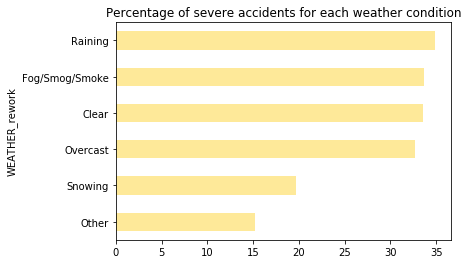

In [25]:
# WEATHER VS SEVERITY
df_plots['WEATHER_rework'] = group_rare_values(df_plots.dropna(subset=['WEATHER']),'WEATHER',0.001)
tmp = df_plots[(df_plots['WEATHER_rework']!='WEATHER_other')&(df_plots['WEATHER_rework']!='Unknown')]
feature_vs_severity(tmp.dropna(subset=['WEATHER_rework']),'WEATHER_rework','Percentage of severe accidents for each weather condition', rotate = True)

/home/ubuntu/anaconda3/envs/myclone_pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


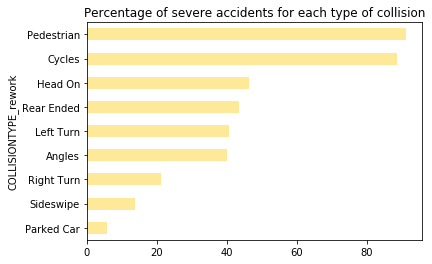

In [26]:
# COLLISIONTYPE VS SEVERITY
df_plots['COLLISIONTYPE_rework'] = group_rare_values(df_plots.dropna(subset=['COLLISIONTYPE']),'COLLISIONTYPE',0.01)
tmp = df_plots[df_plots['COLLISIONTYPE_rework']!='Other']
feature_vs_severity(tmp.dropna(subset=['COLLISIONTYPE_rework']),'COLLISIONTYPE_rework','Percentage of severe accidents for each type of collision', rotate = True)

/home/ubuntu/anaconda3/envs/myclone_pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


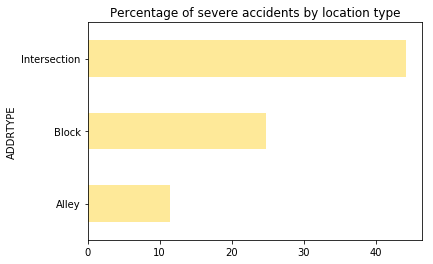

In [27]:
# ADDRTYPE VS SEVERITY
df_plots['ADDRTYPE_rework'] = group_rare_values(df_plots.dropna(subset=['ADDRTYPE']),'ADDRTYPE',0.01)
feature_vs_severity(df_plots.dropna(subset=['ADDRTYPE_rework']),'ADDRTYPE','Percentage of severe accidents by location type', rotate = True)

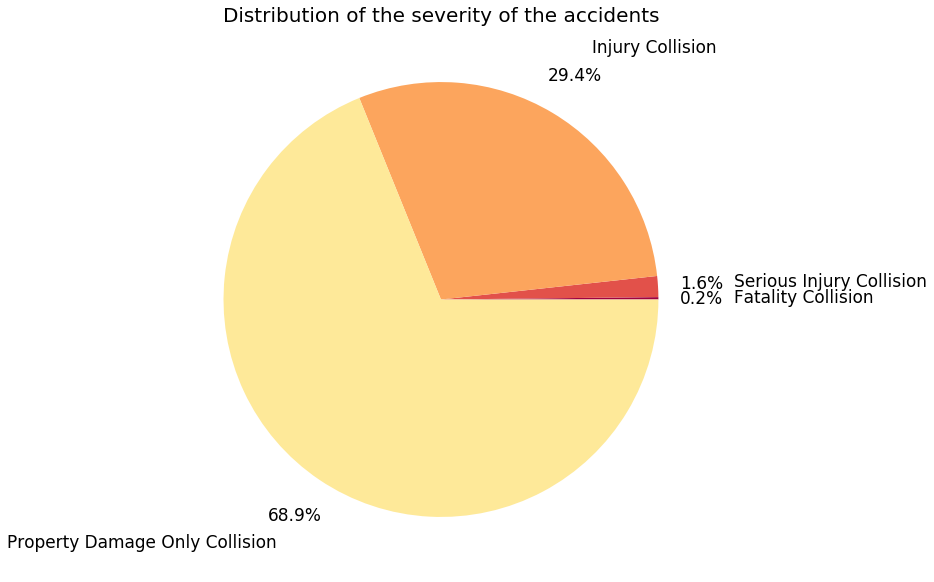

In [28]:
## Total accidents by junction type
type_labels = df_plots['SEVERITYDESC'].value_counts().sort_values().index 
type_counts = df_plots['SEVERITYDESC'].value_counts().sort_values()
plt.figure(1, figsize=(30,10)) 

#the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.subplot(aspect=1)
type_show_ids = plt.pie(type_counts.sort_values(), labels=type_labels, autopct='%1.1f%%', colors=colors, 
                        pctdistance = 1.2, labeldistance=1.35, textprops={'fontsize': 17})
plt.title('Distribution of the severity of the accidents',fontsize= 20)
plt.show()

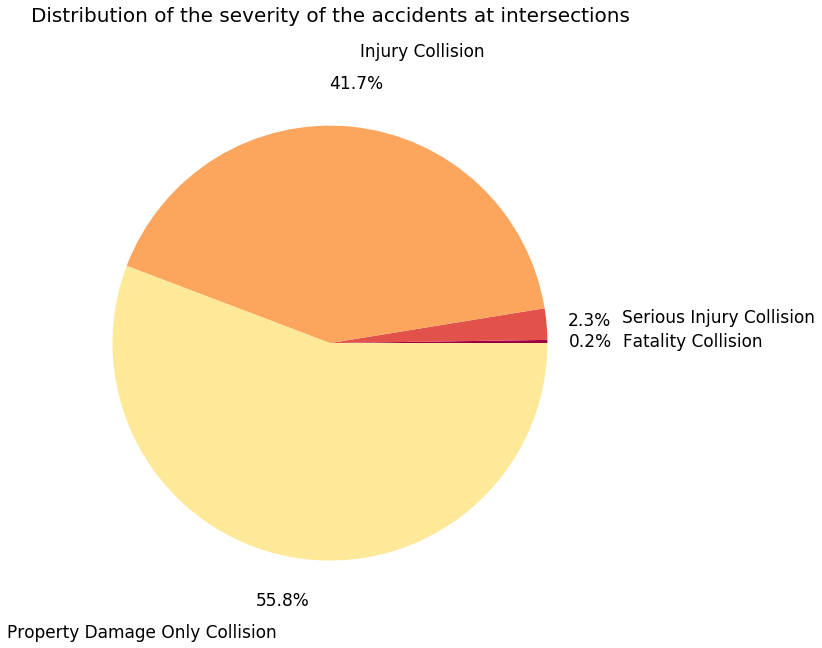

In [29]:
## Total accidents by junction type
df_plots_intersection = df_plots[df_plots['ADDRTYPE']=='Intersection']
type_labels = df_plots_intersection['SEVERITYDESC'].value_counts().sort_values().index 
type_counts = df_plots_intersection['SEVERITYDESC'].value_counts().sort_values()
plt.figure(1, figsize=(30,10)) 

#the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.subplot(aspect=1)
type_show_ids = plt.pie(type_counts.sort_values(), labels=type_labels, autopct='%1.1f%%', colors=colors, 
                        pctdistance = 1.2, labeldistance=1.35, textprops={'fontsize': 17})
plt.title('Distribution of the severity of the accidents at intersections',fontsize= 20,pad=50)

plt.show()

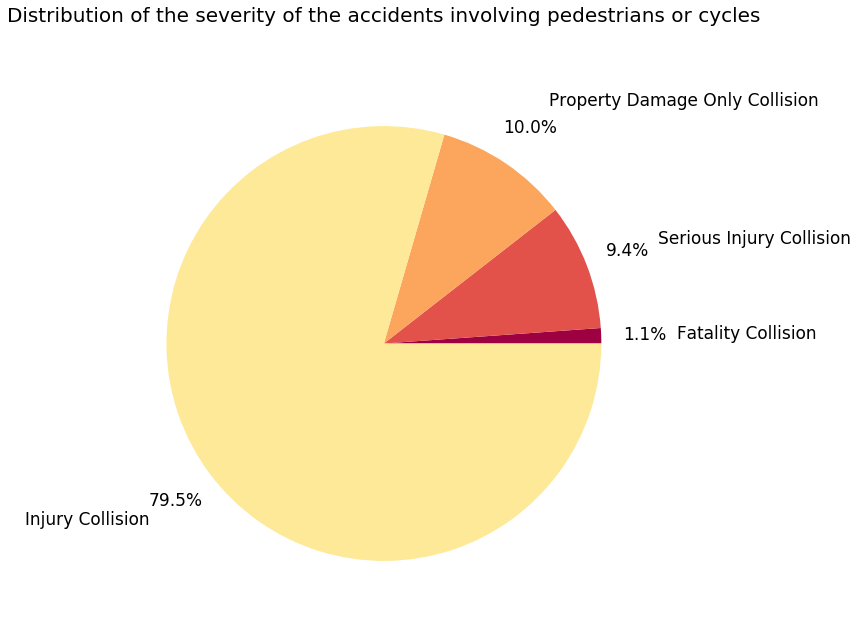

In [30]:
## Total accidents by junction type
df_plots_ped_cycles = df_plots[(df_plots['COLLISIONTYPE']=='Pedestrian')|(df_plots['COLLISIONTYPE']=='Cycles')]
type_labels = df_plots_ped_cycles['SEVERITYDESC'].value_counts().sort_values().index 
type_counts = df_plots_ped_cycles['SEVERITYDESC'].value_counts().sort_values()
plt.figure(1, figsize=(30,10)) 

#the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.subplot(aspect=1)
type_show_ids = plt.pie(type_counts.sort_values(), labels=type_labels, autopct='%1.1f%%', colors=colors, 
                        pctdistance = 1.2, labeldistance=1.35, textprops={'fontsize': 17})
plt.title('Distribution of the severity of the accidents involving pedestrians or cycles',fontsize= 20,pad=50)

plt.show()

In [31]:
# Process the datetime data 

MonkeyPatch.patch_fromisoformat()

df_plots['INCDTTM_rework'] = pd.to_datetime(df_plots['INCDTTM'])
df_plots['DATES'] = pd.to_datetime(df_plots['INCDTTM_rework']).dt.date
df_plots['DAY'] =  pd.to_datetime(df_plots['INCDTTM_rework']).dt.strftime('%a')
df_plots['TIME'] = pd.to_datetime(df_plots['INCDTTM_rework']).dt.time

Text(0.5,1,'Average number of accidents per hour of the day')

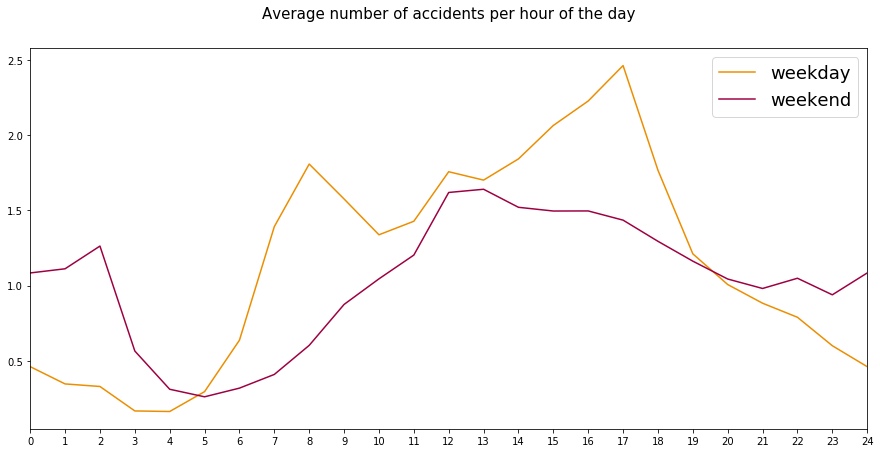

In [32]:
weekdays = ['Mon','Tue','Wed','Thu']
midnight = time.fromisoformat('00:00:00')
hours_week_days = df_plots[(df_plots['TIME']!=midnight) & df_plots['DAY'].isin(weekdays)]
hours_weekend_days = df_plots[(df_plots['TIME']!=midnight) & (df_plots['DAY'].isin(['Sat','Sun']))]

hours_weekday = hours_week_days['TIME'].apply(lambda x : x.hour)
hours_weekend = hours_weekend_days['TIME'].apply(lambda x : x.hour)

hours_weekday_counts = hours_weekday.value_counts()/(4*867)
hours_weekend_counts = hours_weekend.value_counts()/(2*867)

hours_weekday_counts.sort_index(inplace=True)
hours_weekday_counts.name = 'weekday'
hours_weekend_counts.sort_index(inplace=True)
hours_weekend_counts.name = 'weekend'

finaldf = pd.concat([hours_weekday_counts, hours_weekend_counts], axis=1)
finaldf.loc[24] = finaldf.loc[0]
lines = finaldf.plot.line(xticks=range(25),color=['#EC8E00','#9e0142'],figsize=(15,7)).legend(prop={'size': 18})
plt.title('Average number of accidents per hour of the day',fontsize= 15,pad=30)


Text(0.5,1,'Average number of accidents involving someone under influence per hour of the day')

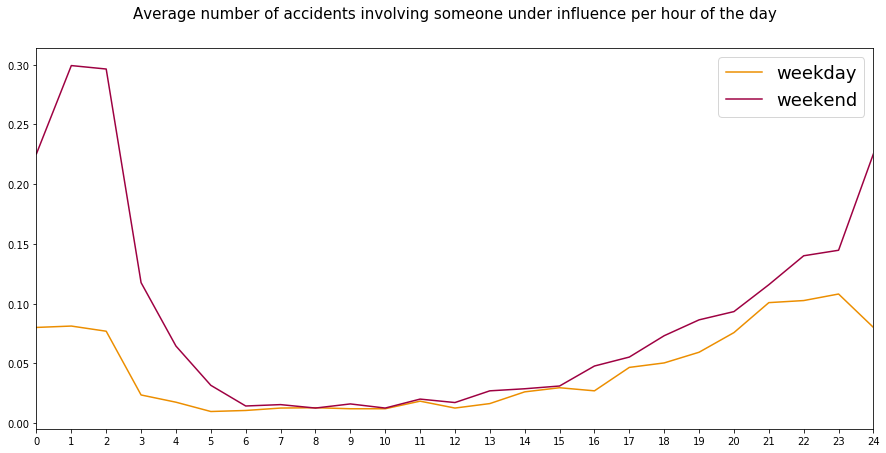

In [33]:
weekdays = ['Mon','Tue','Wed','Thu']
midnight = time.fromisoformat('00:00:00')
hours_week_days = df_plots[(df_plots['TIME']!=midnight) & df_plots['DAY'].isin(weekdays)]
hours_weekend_days = df_plots[(df_plots['TIME']!=midnight) & (df_plots['DAY'].isin(['Sat','Sun']))]

hours_week_days = hours_week_days[(hours_week_days['UNDERINFL']=='Y') | (hours_week_days['UNDERINFL']=='1')]
hours_weekend_days = hours_weekend_days[(hours_weekend_days['UNDERINFL']=='Y') | (hours_weekend_days['UNDERINFL']=='1')]

hours_weekday = hours_week_days['TIME'].apply(lambda x : x.hour)
hours_weekend = hours_weekend_days['TIME'].apply(lambda x : x.hour)

hours_weekday_counts = hours_weekday.value_counts()/(4*867)
hours_weekend_counts = hours_weekend.value_counts()/(2*867)

hours_weekday_counts.sort_index(inplace=True)
hours_weekday_counts.name = 'weekday'
hours_weekend_counts.sort_index(inplace=True)
hours_weekend_counts.name = 'weekend'

finaldf = pd.concat([hours_weekday_counts, hours_weekend_counts], axis=1)
finaldf.loc[24] = finaldf.loc[0]
lines = finaldf.plot.line(xticks=range(25),color=['#EC8E00','#9e0142'],figsize=(15,7)).legend(prop={'size': 18})
plt.title('Average number of accidents involving someone under influence per hour of the day',fontsize= 15,pad=30)

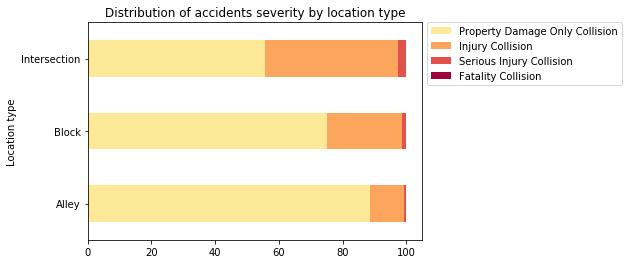

In [34]:
df_plots['ADDRTYPE_rework'] = df_plots['ADDRTYPE']
tmp=df_plots.groupby(['ADDRTYPE_rework','SEVERITYDESC']).size().unstack().rename_axis(index= 'Location type')
tmp.fillna(0,inplace=True)
tmp["sum"] = tmp.sum(axis=1)

tmp = tmp.div(tmp["sum"], axis=0)

del tmp['sum']

tmp = tmp[['Property Damage Only Collision','Injury Collision','Serious Injury Collision','Fatality Collision']]

(tmp*100).plot(kind='barh',stacked=True, title= 'Distribution of accidents severity by location type', \
                  color = ['#fee999', '#fca55d', '#e2514a','#9e0142']).legend(loc='center left', bbox_to_anchor=(1.0, 0.858))

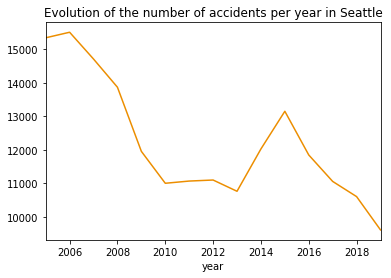

In [35]:
df_plots['year'] = df_plots['INCDTTM_rework'].apply(lambda x : x.year)

df_plots['week_number'] = df_plots['DATES'].apply(lambda x : x.isocalendar()[1])

before_2020 = df_plots[(df_plots['year']!=2020)&(df_plots['year']!=2004)]
before_2020.groupby('year').size().plot(kind='line', color = '#EC8E00',title = 'Evolution of the number of accidents per year in Seattle')

df_2020 = df_plots[(df_plots['year']==2020)& (df_plots['week_number']<34)]
df_2019 = df_plots[(df_plots['year']==2019)& (df_plots['week_number']<34)]

to_plot_2020 = df_2020.groupby('week_number').size()
to_plot_2019 = df_2019.groupby('week_number').size()

to_plot_2020.name = '2020'
to_plot_2019.name = '2019'

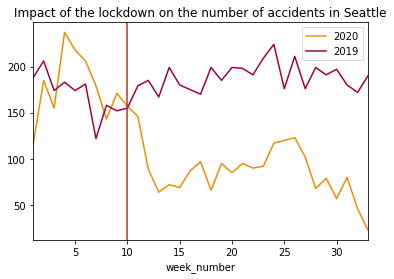

In [36]:
ax=to_plot_2020.plot(kind='line', color = '#EC8E00',legend = True,title = 'Impact of the lockdown on the number of accidents in Seattle')
ax=to_plot_2019.plot(kind='line', color = '#9e0142',legend=True)

ax.axvline(x=10,color='#AC361E')

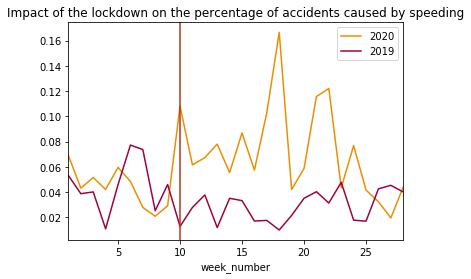

In [37]:
dico_2020=df_2020['week_number'].value_counts().to_dict()
dico_2019=df_2019['week_number'].value_counts().to_dict()

df_2020_speeding = df_plots[(df_plots['year']==2020)& (df_plots['week_number']<29)&(df_plots['SPEEDING']=='Y')]
df_2019_speeding = df_plots[(df_plots['year']==2019)& (df_plots['week_number']<29)&(df_plots['SPEEDING']=='Y')]
new_values=[]
df_2020_size = df_2020_speeding.groupby('week_number').size()
for row in df_2020_size.iteritems():
    new_values.append(row[1]/dico_2020[row[0]])
df_2020_speeding_size = pd.Series(new_values,index = df_2020_size.index)

new_values = []
df_2019_size = df_2019_speeding.groupby('week_number').size()
for row in df_2019_size.iteritems():
    new_values.append(row[1]/dico_2019[row[0]])
df_2019_speeding_size = pd.Series(new_values,index = df_2019_size.index)

df_2020_speeding_size.name = '2020'
df_2019_speeding_size.name = '2019'

ax=df_2020_speeding_size.plot(legend = True,kind='line',color = "#EC8E00",title = 'Impact of the lockdown on the percentage of accidents caused by speeding')
ax=df_2019_speeding_size.plot(legend= True,kind='line',color = '#9e0142')

ax.axvline(x=10,color='#AC361E')

In [38]:
# Transform into datetime format
df_plots['INCDTTM_rework'] = pd.to_datetime(df_plots['INCDTTM'])

# Split dates and times
df_plots['DATES'] = pd.to_datetime(df_plots['INCDTTM_rework']).dt.date
df_plots['TIME'] = pd.to_datetime(df_plots['INCDTTM_rework']).dt.time

# Extract month and weekday
df_plots['MONTH'] = df_plots['INCDTTM_rework'].dt.strftime('%b')
df_plots['DAY'] = df_plots['INCDTTM_rework'].dt.strftime('%a')


# Create variables to split times into categories
MonkeyPatch.patch_fromisoformat()

night = time.fromisoformat('21:00:00')
night_end_day = time.fromisoformat('23:59:59')
late_night = time.fromisoformat('00:01:00')
rush_am = time.fromisoformat('07:00:00')
empty_am = time.fromisoformat('09:00:00')
lunch = time.fromisoformat('12:00:00')
empty_pm = time.fromisoformat('13:00:00')
rush_pm = time.fromisoformat('17:00:00')
afterwork = time.fromisoformat('18:00:00')

# Apply the function get_cat_hour to the column TIME
df_plots['MOMENT_OF_DAY'] = df_plots['TIME'].apply(get_cat_hour)

# Apply the function get_cat_day to the column DAY
df_plots['WKDAY'] = df_plots['DAY'].apply(get_cat_day)

In [39]:
df_plots['MOMENT_OF_DAY'].value_counts()

afternoon    45625
unknown      30843
morning      24284
evening      23905
mid_night    19276
night        16126
rush_am      15494
rush_pm      13319
lunch        10652
Name: MOMENT_OF_DAY, dtype: int64

In [40]:
### Folium

In [41]:
df_plots['LOCATION_rework'] = df_plots['LOCATION'].fillna('unknown')
subset_df_dict = df_plots[(df_plots['SEVERITYCODE']!='1')&(df_plots['ADDRTYPE_rework']=='Intersection')]['LOCATION_rework'].value_counts().to_dict()

subset_df_top = list(subset_df_dict)[:50]
gps_coordinates_top = pd.Series(subset_df_top).apply(lambda x : location_dict[x])
mask = gps_coordinates_top.apply(lambda x : True if "nan" not in str(x) else False)
gps_coordinates_top = gps_coordinates_top[mask]

In [42]:
a=list(subset_df_dict.values())[:50]
b=[((x-min(a))+1)*3 for x in a]

In [43]:
map_ = folium.Map(location=[47.6062,-122.3321], zoom_start=10)

#marker_cluster = folium.plugins.MarkerCluster().add_to(map_)

#marker_cluster = MarkerCluster().add_to(map_)
loc_list = gps_coordinates_top.values.tolist()
loc_list = [list((x[1],x[0])) for x in loc_list]
# To display all data use the following two lines, but, since your data has
# so many points, this process will be time-consuming.
for point in range(0, len(loc_list)):
    folium.vector_layers.CircleMarker(loc_list[point],radius = b[point]*0.1,color = 'red',fill=True).add_to(map_)

map_.save('folium_map.html')

## 1b) Data preprocessing

In [44]:
# Basic preprocessing to remove the target with the NaNs and Unknown target values

df = df[df['SEVERITYCODE']!='0']
df['SEVERITYCODE'] = df['SEVERITYCODE'].apply(process_target)
df.dropna(subset=['SEVERITYCODE'],inplace=True)
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
2,1.265803e+06,269008.050248,3,1358,1358,3568600,Matched,Block,NaN,GREENWOOD AVE N BETWEEN N 134TH ST AND N 136TH ST,...,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
3,1.274389e+06,229235.950879,4,70700,70700,2806057,Matched,Block,NaN,E DENNY WAY BETWEEN 11TH AVE AND 12TH AVE,...,Dry,Other,NaN,7065007.0,NaN,32,One parked--one moving,0,0,N
4,1.263093e+06,200192.534913,5,53600,53600,2127310,Matched,Block,NaN,DELRIDGE WAY SW BETWEEN SW MYRTLE ST AND SW OR...,...,Dry,Daylight,NaN,6137017.0,NaN,14,From same direction - both going straight - on...,0,0,N
5,1.256925e+06,209863.662731,6,1197,1197,3553269,Matched,Intersection,31893.0,CALIFORNIA AVE SW AND SW GENESEE ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
6,1.261803e+06,195627.193788,7,39300,39300,1076530,Matched,Block,NaN,26TH AVE SW BETWEEN SW CLOVERDALE ST AND DEAD ...,...,Dry,Dark - Street Lights On,NaN,5149018.0,NaN,32,One parked--one moving,0,0,N


In [45]:
# Fill manually the NaNs values when we don't want to be replaced by the mean
df['SPEEDING'].fillna('N',inplace=True)
df['INATTENTIONIND'].fillna('N',inplace=True)
df['LOCATION_rework'] = df['LOCATION'].fillna('unknown')

In [46]:
# List of continuous features
cont_cols = ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

# List of categorical features
cat_cols = [ x for x in df.columns if (x not in cont_cols and x!= 'SEVERITYCODE')]

useless_col = []

### Outliers

### Missing values

In [47]:
# List of columns with too many missing values (20% of missing values and more)
missing_values = (df.isnull().sum() / len(df)) >= 0.20 
col_too_many_missing = missing_values[missing_values==True].index
print('Columns with more than 20 percent of missing values :')
print()
print(col_too_many_missing)

Columns with more than 20 percent of missing values :

Index(['INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'PEDROWNOTGRNT',
       'SDOTCOLNUM'],
      dtype='object')


In [48]:
# Fillna with mean for continuous columns
for col in cont_cols :
    if col in df.columns: 
        df[col] = df[col].fillna(df[col].mean())
        
# Fillna with mode (highest frequency) for cat columns
for col in cat_cols : 
    if col in df.columns :
        df[col] = df[col].fillna(df[col].mode()[0])

### Feature engineering

In [49]:
## Create columns that tells if a location had more than 10 severe accidents in the past

severe_locations = df[df['SEVERITYCODE']==2]['LOCATION'].value_counts()
often_severe_locations = severe_locations[severe_locations>10]
often_severe_locations_dict = often_severe_locations.to_dict()
df['dangerous_locations'] = df['LOCATION_rework'].apply(lambda x : 1 if x in  often_severe_locations_dict else 0)

In [50]:
location_danger_dict =  (df.groupby('LOCATION_rework')['SEVERITYCODE'].mean()-1).to_dict()
location_number_accidents_dict = df['LOCATION_rework'].value_counts().to_dict()
x=df['LOCATION_rework'].value_counts()

# Create a feature that display the number of accidents at a certain location
df['LOCATION_number_accidents'] = df['LOCATION_rework'].apply(lambda x : location_number_accidents_dict[x])

In [51]:
# We add the new created features to the continuous feature list and we add LOCATION_rework to the useless columns 
# since we don't need it anymore.

cont_cols.extend(['LOCATION_number_accidents','dangerous_locations'])
useless_col.append('LOCATION_rework')

In [52]:
# We group the Y and 1 / N and 0 

df['UNDERINFL'] = df['UNDERINFL'].apply(process_underinfl)

In [53]:
# Transform into datetime format
df['INCDTTM_rework'] = pd.to_datetime(df['INCDTTM'])

# Split dates and times
df['DATES'] = pd.to_datetime(df['INCDTTM_rework']).dt.date
df['TIME'] = pd.to_datetime(df['INCDTTM_rework']).dt.time

# Extract month and weekday
df['MONTH'] = df['INCDTTM_rework'].dt.strftime('%b')
df['DAY'] = df['INCDTTM_rework'].dt.strftime('%a')


# Create variables to split times into categories
MonkeyPatch.patch_fromisoformat()

night = time.fromisoformat('21:00:00')
night_end_day = time.fromisoformat('23:59:59')
late_night = time.fromisoformat('00:01:00')
rush_am = time.fromisoformat('07:00:00')
empty_am = time.fromisoformat('09:00:00')
lunch = time.fromisoformat('12:00:00')
empty_pm = time.fromisoformat('13:00:00')
rush_pm = time.fromisoformat('17:00:00')
afterwork = time.fromisoformat('18:00:00')

# Apply the function get_cat_hour to the column TIME
df['MOMENT_OF_DAY'] = df['TIME'].apply(get_cat_hour)

# Apply the function get_cat_day to the column DAY
df['WKDAY'] = df['DAY'].apply(get_cat_day)

#  2) <u> Correlation analysis & feature selection </u>

## 2a) Useless columns for our analysis

In [54]:
# List all columns that we need to delete for our analysis (Data leakage or not useful)
useless_col.extend(['X','Y','SERIOUSINJURIES','FATALITIES','INJURIES','OBJECTID','INCKEY','COLDETKEY','REPORTNO','LOCATION','EXCEPTRSNCODE',
                   'EXCEPTRSNDESC','SEVERITYCODE.1','SEVERITYDESC','INCDATE',
                   'CROSSWALKKEY', 'SEGLANEKEY','X','Y','HITPARKEDCAR'])

useless_col.extend(['INCDTTM', 'INCDTTM_rework', 'DATES', 'TIME', 'MONTH', 'DAY', 'PERSONCOUNT', 'PEDCOUNT', 
                    'PEDCYLCOUNT', 'VEHCOUNT', 'COLLISIONTYPE'])
# Delete all not useful columns
df = df[[x for x in list(df.columns) if x not in useless_col]]

In [55]:
# Delete columns with too many missing values
df = df[[ x for x in list(df.columns) if x not in col_too_many_missing ]]
df.columns

Index(['STATUS', 'ADDRTYPE', 'SEVERITYCODE', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'dangerous_locations', 'LOCATION_number_accidents', 'MOMENT_OF_DAY',
       'WKDAY'],
      dtype='object')

## 2b) Correlations among features

### Continuous variables

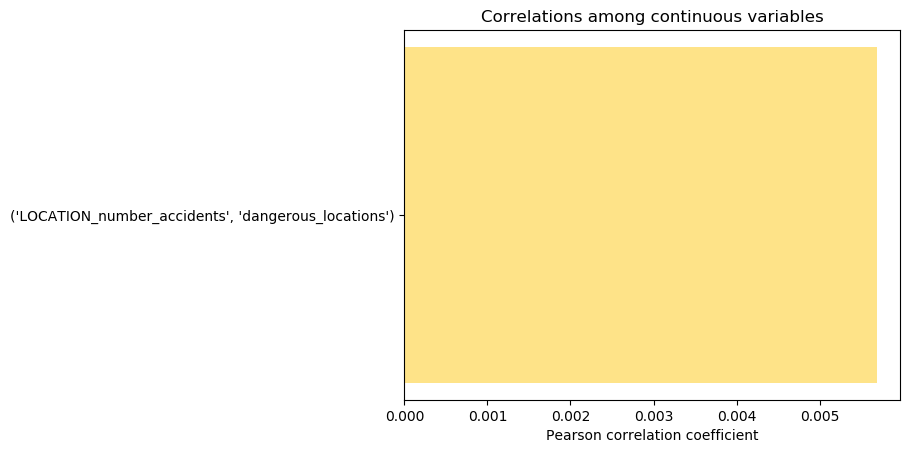

In [56]:
tmp=get_pearson_score(df, cont_cols)
formated_tmp = list(zip(zip(tmp.col_a, tmp.col_b),list(tmp.pearson)))
display_top_features(formated_tmp,x_title='Pearson correlation coefficient',plot_title='Correlations among continuous variables')

### Categorical variables

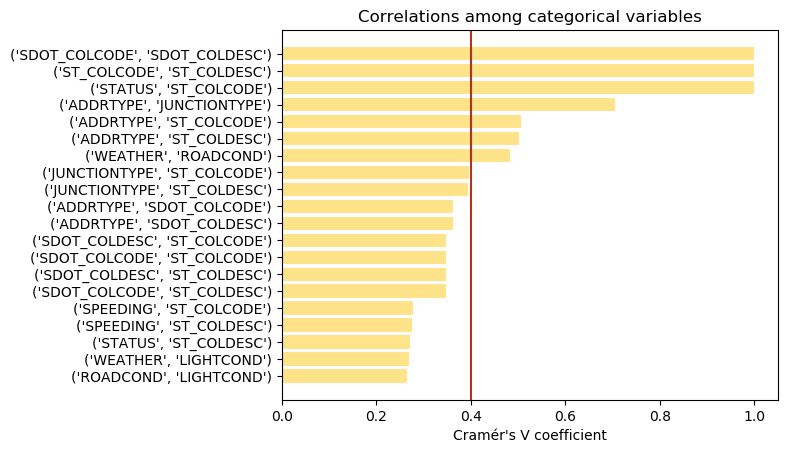

In [57]:
tmp=get_cramer_score(df, cat_cols)
formated_tmp = list(zip(zip(tmp.col_a, tmp.col_b),list(tmp.cramers)))
display_top_features(formated_tmp,x_title="Cramér's V coefficient",plot_title='Correlations among categorical variables')

## 2c) Correlations with target variable

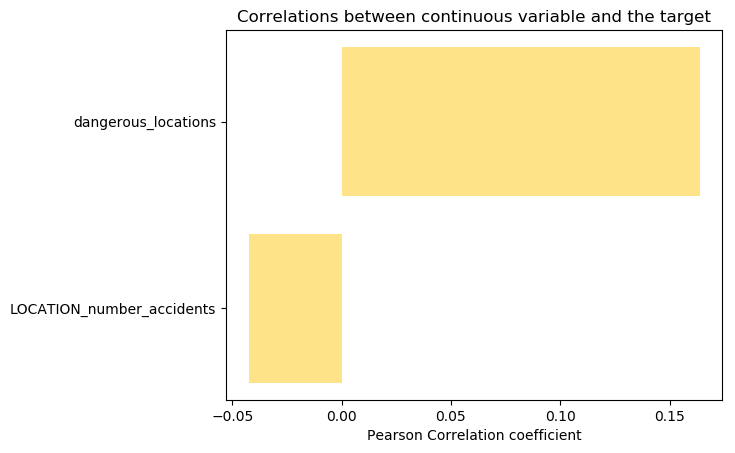

In [58]:
tmp=get_cont_corr_with_target(df, cont_cols)
formated_tmp = list(zip(tmp.col_a,list(tmp.pearson)))
display_top_features(formated_tmp,x_title='Pearson Correlation coefficient',plot_title='Correlations between continuous variable and the target')

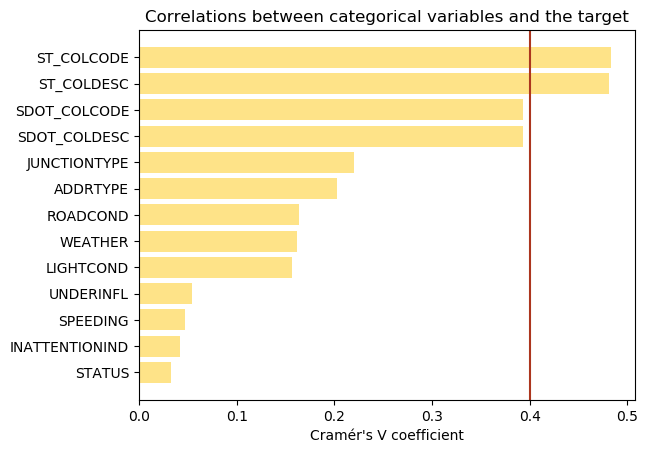

In [59]:
tmp=get_cat_corr_with_target(df, cat_cols)
formated_tmp = list(zip(tmp.col_a,list(tmp.cramers)))
display_top_features(formated_tmp,x_title="Cramér's V coefficient",plot_title='Correlations between categorical variables and the target')

In [60]:
# Delete columns too correlated (> 0.6)
useless_col.extend(['SDOT_COLDESC', 'STATUS','SDOT_COLCODE', 'ADDRTYPE', 'ST_COLCODE','ST_COLDESC'])
df = df[[x for x in list(df.columns) if x not in useless_col]]

## 2d) Getting dummies of categorical variables

In [61]:
df.columns

Index(['SEVERITYCODE', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'dangerous_locations',
       'LOCATION_number_accidents', 'MOMENT_OF_DAY', 'WKDAY'],
      dtype='object')

In [62]:
# Get dummies
X= df[[x for x in list(df.columns) if x in cat_cols and x!= 'SEVERITYCODE']]
X = pd.get_dummies(X, prefix = [x for x in X.columns], columns = [x for x in X.columns])

for cont_col in cont_cols:
    if cont_col in df.columns:
        X[cont_col] = df[cont_col]

y= df['SEVERITYCODE'].apply(lambda x : 0 if x==1 else 1)

In [63]:
unknowns = ['WEATHER_Unknown','LIGHTCOND_Unknown','ROADCOND_Unknown']
X = X[[x for x in X.columns if x not in unknowns]]

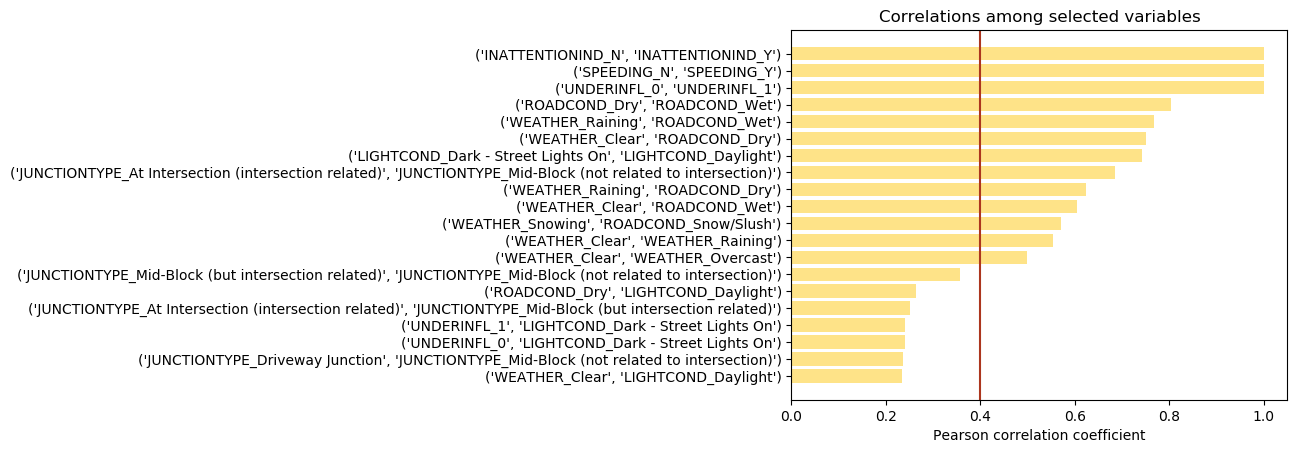

In [64]:
tmp=get_pearson_score(X, X.columns)
formated_tmp = list(zip(zip(tmp.col_a, tmp.col_b),list(tmp.pearson)))
display_top_features(formated_tmp,x_title='Pearson correlation coefficient',plot_title='Correlations among selected variables')

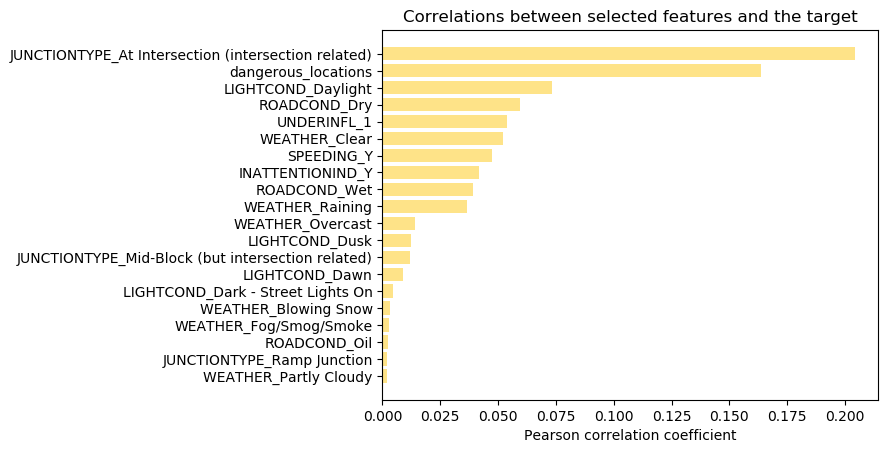

In [65]:
tmp=get_corr_to_target(X, y)
formated_tmp = list(zip(tmp.col_a,list(tmp.pearson)))
display_top_features(formated_tmp,x_title='Pearson correlation coefficient',plot_title='Correlations between selected features and the target')

In [66]:
# Exclude correlated dummies
correlated_dummies = ['SDOT_COLDESC_MOTOR VEHCILE STRUCK PEDESTRIAN', 'WEATHER_Unknown', 'WEATHER_Raining', 
                      'ROADCOND_Dry', 'LIGHTCOND_Unknown', 
                      'SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE',
                      'SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END', 'WKDAY_Weekend', 
                      'HITPARKEDCAR_N',
                      'UNDERINFL_N', 'LIGHTCOND_Daylight', 'JUNCTIONTYPE_Mid-Block (not related to intersection)', 
                      'WEATHER_Clear', 'UNDERINFL_0']

X= X[[x for x in X.columns if x not in correlated_dummies]]

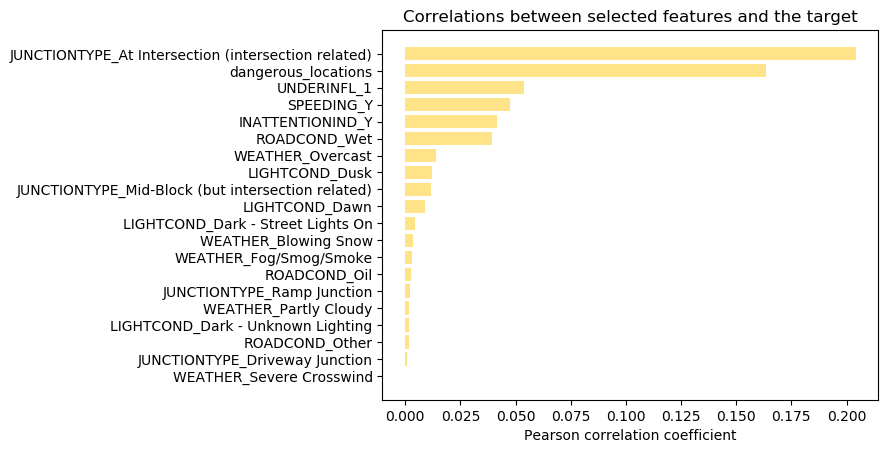

In [67]:
tmp=get_corr_to_target(X, y)
formated_tmp = list(zip(tmp.col_a,list(tmp.pearson)))
display_top_features(formated_tmp,x_title='Pearson correlation coefficient',plot_title='Correlations between selected features and the target')

In [68]:
X = X[[x for x in X.columns if x not in ['ROADCOND_Unknown','JUNCTIONTYPE_Unknown']]]

<a id='section_ml'></a>
# 3) <u>   Machine Learning </u>

## 3a) Model Selection

### Splitting the data

In [69]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)

## Rebalancing

In [70]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.75,random_state=42)

X_train, y_train = rus.fit_resample(X_train, y_train)

y_train.value_counts()

0    62041
1    46531
Name: SEVERITYCODE, dtype: int64

from imblearn import *

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

y_train.value_counts()

### Performing a gridsearch

In [71]:
param_xgboost = {
    'n_estimators': [50, 100, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

param_decision_tree = {'max_depth': [4,6,8,12,None], 'max_features': ['auto', 'sqrt', 'log2']}

param_random_forest = {'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']}

param_log_regression = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1]}

dico = { 'xbgoost' : (XGBClassifier(n_jobs=15), param_xgboost), 
        'dec_tree' : (DecisionTreeClassifier(), param_decision_tree), 
        'random_f' : (RandomForestClassifier(n_jobs=15), param_random_forest), 
        'log_reg' : (LogisticRegression(n_jobs=15), param_log_regression) }

In [72]:
results = {}
for item in dico: 
    print(item)
    gd_sr = GridSearchCV(estimator = dico[item][0] , param_grid = dico[item][1], 
                         scoring='f1_micro', cv=2, n_jobs=15)
    gd_sr.fit(X_train, y_train)
    results[item] = gd_sr
    preds = gd_sr.best_estimator_.predict(X_test)
    print(f1_score(preds,y_test,average='micro'))
    print()
    print('________')

xbgoost
[05:59:33] WARNING: ../src/learner.cc:516: 
Parameters: { bootstrap, criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.6530743168741605

________
dec_tree
0.6524929331809707

________
random_f
0.636775525751288

________
log_reg
0.6639401776227422

________


for item in results:
    tmp_res = results[item]
    print(item)
    print(tmp_res.best_score_)
    print(tmp_res.best_estimator_)
    print()
    print('__________________')

clf = XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=True,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='gini', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=50, n_jobs=15,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1)

## 3b) Model evaluation

In [73]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
model = Pipeline([
        ('sampling', RandomUnderSampler(sampling_strategy=0.75,random_state=42)),
        ('classification', LogisticRegression(C=0.01, n_jobs=15))
    ])

scores=cross_val_score(model, X, y, cv=5,scoring='f1_micro',n_jobs=15)
scores.mean()

0.667197848951002

In [74]:
clf = LogisticRegression(C=0.01, n_jobs=15)
clf.fit(X_train, y_train)
# We make predictions on the unseen Test data with the best estimator (Based on the gridsearch results)
preds=clf.predict(X_test)
print(f1_score(preds,y_test, average='micro'))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

0.6684910086004691
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     34302
           1       0.46      0.39      0.42     15579

    accuracy                           0.67     49881
   macro avg       0.60      0.59      0.59     49881
weighted avg       0.65      0.67      0.66     49881

[[27342  6960]
 [ 9576  6003]]


a=list(zip((X.columns),clf.feature_importances_))
b=sorted(a, key = lambda x: abs(x[1]),reverse=True)
display_top_features(b,plot_title='Feature importances (according to model)',x_title='Importance')

# 4) <u> Error analysis & interpretation <u>

In [75]:
bad_predictions = X_test[preds!=y_test]

bad_predictions['PRED'] = preds[preds!=y_test]

bad_predictions

/home/ubuntu/anaconda3/envs/myclone_pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Ramp Junction,INATTENTIONIND_N,INATTENTIONIND_Y,UNDERINFL_1,WEATHER_Blowing Sand/Dirt,WEATHER_Blowing Snow,...,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Dusk,LIGHTCOND_Other,SPEEDING_N,SPEEDING_Y,LOCATION_number_accidents,dangerous_locations,PRED
65615,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,17,0,0
138734,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,73,1,1
184550,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,87,1,0
174743,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,221,1,0
54364,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,40,1,1
167246,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,58,1,1
47307,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,52,1,0
110621,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,7,0,0
20275,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,279,1,0
74315,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,43,1,1
